# Explorative Data Analysis and Visualization
## Course Code: DLBDSEDAV01

# Task 1:  Visually Exploring a Data Set

This notebook contains the implementation of Task 1 of the Explorative Data Analysis and Visualization course (DLBDSEDAV01) and it describes the analysis of the _Electric Vehicle Specs Dataset (2025)_.

The notebook includes statistical analysis of the features of the dataset, the corresponding visualizations and conculsions based on the data shown. The implementation steps and design decisions regarding the visualizations are omitted here. They are included in the Written Assignment that accompanies this notebook.

Since the visualizations presented here are part of the written assignment, the titles of the figures are included in the corresponding captions (Fundamental of Data Visualization - C. Wilke).

# 1. Dataset information

- __Name__: Electric Vehicle Specs Dataset (2025)
- __Source__: [Kaggle](https://www.kaggle.com/datasets/urvishahir/electric-vehicle-specifications-dataset-2025/data)
- __Features included__:
  
    - __Brand and Model__: Manufacturer and specific nameplate of the EV.
    - __Car Body Type__: Classification such as hatchback, SUV, sedan, etc.
    - __Segment__: Vehicle segment (e.g., compact, midsize, executive).
    - __Battery Capacity (kWh)__: The gross energy capacity of the battery.
    - __Number of Cells and Battery Type__: Technical battery information, where available.
    - __Efficiency (Wh/km)__: Power consumption rate of the vehicle.
    - __Range (km)__: Estimated driving range on a full charge.
    - __Fast Charging Power (kW)__: Maximum supported DC fast-charging power.
    - __Fast Charge Port Type__: Connector standard (e.g., CCS, CHAdeMO).
    - __Top Speed (km/h)__: Maximum speed of the vehicle.
    - __0–100 km/h Acceleration (s)__: Time to reach 100 km/h from a standstill.
    - __Torque (Nm)__: Maximum torque output, where available.
    - __Towing Capacity (kg)__: Ability to tow loads, provided where applicable.
    - __Cargo Volume (L)__: Luggage space, sometimes approximate or expressed in alternative units.
    - __Seats__: Total seating capacity.
    - __Length, Width, Height (mm)__: Physical footprint of the vehicle.
    - __Drivetrain__: Powertrain configuration (e.g., AWD, RWD, FWD).
    - __Source URL__: Reference link for each car in the [EV database](https://ev-database.org/).

In [1]:
# For exact versions of the modules see environment.yml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from itertools import combinations
from scipy import stats
import statsmodels.api as sm

# 2. Understanding the data

Before starting with analysis of the data and calculation of statistics, the data set is examined to understand its structure, size, datatypes, missing values, etc.

In [2]:
# Take a look at the original dataset
df = pd.read_csv(r"../data/electric_vehicles_spec_2025.csv")
df.head(10)

,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,...,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...
4,Aiways,U5,150,60.0,Lithium-ion,NaN,310.0,156,315,7.5,...,NaN,496,5,FWD,JC - Medium,4680,1865,1700,SUV,https://ev-database.org/car/1678/Aiways-U5
5,Aiways,U6,160,60.0,Lithium-ion,NaN,315.0,150,350,7.0,...,NaN,472,5,FWD,JC - Medium,4805,1880,1641,SUV,https://ev-database.org/car/1766/Aiways-U6
6,Alfa,Romeo Junior Elettrica 54 kWh,150,50.8,Lithium-ion,102.0,260.0,128,320,9.0,...,0.0,400,5,FWD,JB - Compact,4173,1781,1532,SUV,https://ev-database.org/car/2184/Alfa-Romeo-Ju...
7,Alfa,Romeo Junior Elettrica 54 kWh Veloce,200,50.8,Lithium-ion,102.0,345.0,164,310,6.0,...,0.0,400,5,FWD,JB - Compact,4173,1781,1505,SUV,https://ev-database.org/car/2185/Alfa-Romeo-Ju...
8,Alpine,A290 Electric 180 hp,160,52.0,Lithium-ion,184.0,285.0,138,310,7.4,...,500.0,326,5,FWD,B - Compact,3997,1823,1512,Hatchback,https://ev-database.org/car/2268/Alpine-A290-E...
9,Alpine,A290 Electric 220 hp,170,52.0,Lithium-ion,184.0,300.0,144,305,6.4,...,500.0,326,5,FWD,B - Compact,3997,1823,1512,Hatchback,https://ev-database.org/car/2269/Alpine-A290-E...


In [3]:
# number of entries, column names, datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand                      478 non-null    object 
 1   model                      477 non-null    object 
 2   top_speed_kmh              478 non-null    int64  
 3   battery_capacity_kWh       478 non-null    float64
 4   battery_type               478 non-null    object 
 5   number_of_cells            276 non-null    float64
 6   torque_nm                  471 non-null    float64
 7   efficiency_wh_per_km       478 non-null    int64  
 8   range_km                   478 non-null    int64  
 9   acceleration_0_100_s       478 non-null    float64
 10  fast_charging_power_kw_dc  477 non-null    float64
 11  fast_charge_port           477 non-null    object 
 12  towing_capacity_kg         452 non-null    float64
 13  cargo_volume_l             477 non-null    object 

In [4]:
# Check for missing values. Those columns that have many missing values will be dropped since imputing lots of values can
# enter bias into the data set
df.isnull().sum().to_frame('Missing Values').style.background_gradient(cmap='Reds')

,Missing Values
brand,0
model,1
top_speed_kmh,0
battery_capacity_kWh,0
battery_type,0
number_of_cells,202
torque_nm,7
efficiency_wh_per_km,0
range_km,0
acceleration_0_100_s,0


In [5]:
# Check for the unique values in the dataset. The columns that have only one value can be dropped since
# this values alone does not provide any information relevant for this analysis
df.nunique().sort_values().to_frame("Unique values").style.background_gradient(cmap='Blues')

,Unique values
battery_type,1
fast_charge_port,2
drivetrain,3
seats,7
car_body_type,8
segment,15
towing_capacity_kg,26
top_speed_kmh,38
number_of_cells,38
brand,59


In [6]:
df.fast_charge_port.value_counts()

fast_charge_port
CCS        476
CHAdeMO      1
Name: count, dtype: int64

Based on this results these columns can be dropped:
1. number_of_cells: Around 40% of the values in this columns are missing.
2. battery_type: this columns offers only one unique value _Lithium-ion_. It does not provide information relevant for the current analysis.
3. source_url: the urls contain in this column point to [EV-Database](https://ev-database.org/). It is not relevant for this analysis.
4. From the 477 vehicles with Fast Charge Port data, 476 of them use the CCS and only one does not. Not much information for the analysis.

In [7]:
# Since there is only one battery type, this column does provide useful information for this analysis we can drop it
df = df.drop(["number_of_cells", "battery_type", "fast_charge_port", "source_url"], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand                      478 non-null    object 
 1   model                      477 non-null    object 
 2   top_speed_kmh              478 non-null    int64  
 3   battery_capacity_kWh       478 non-null    float64
 4   torque_nm                  471 non-null    float64
 5   efficiency_wh_per_km       478 non-null    int64  
 6   range_km                   478 non-null    int64  
 7   acceleration_0_100_s       478 non-null    float64
 8   fast_charging_power_kw_dc  477 non-null    float64
 9   towing_capacity_kg         452 non-null    float64
 10  cargo_volume_l             477 non-null    object 
 11  seats                      478 non-null    int64  
 12  drivetrain                 478 non-null    object 
 13  segment                    478 non-null    object 

In [8]:
# This mapping is used though out the notebook to properly rename the axis of the plots
xlabel_map = {
    "range_km" : "Range (km)",
    "torque_nm" : "Torque (Nm)",
    "top_speed_kmh" : "Top Speed (km/h)",
    "battery_capacity_kWh" : "Battery Capacity (kWh)",
    "fast_charging_power_kw_dc" : "Fast Charging Power (kW)",
    "acceleration_0_100_s" : "Acceleration 0-100 km/h (s)",
    "efficiency_km_kWh" : "Efficiency (km/kWh)",
    "drivetrain" : "Drivetrain",
    "new_segment" : "New Segment"
}

In [9]:
# Ensure consistency between the colors of the plots
# Fixed segment order
segment_order = ["Passenger Van", "Mini & Compact", "Medium", "Large & Executive", "Luxury & Sports"]

# Define a custom color palette mapping
segment_palette = {
    "Passenger Van": "#1f77b4",       # Blue
    "Mini & Compact": "#ff7f0e",      # Orange
    "Medium": "#2ca02c",              # Green
    "Large & Executive": "#d62728",   # Red
    "Luxury & Sports": "#9467bd"      # Purple
}

# 3 Analysis across all vehicles
## 3.1 Number of vehicles per brand

We see that the German brands are amogst the brands with the highest number of models, with Mercedes-Benz leading the charts with 42 models., followed by Audi, Porsche and Volkswagen.

Firefly was another intereting case as a data point, since there is no name for a model so it was not counted at first, to deal with this, the value for the count is set manually to one.

In [10]:
df.brand.unique().shape

(59,)

In [11]:
# count the models by each brand and sort them from highest to lowest
n_model_by_brand = df.loc[:,["brand", "model"]].groupby("brand").count().sort_values("model", ascending=False)
display(n_model_by_brand.tail())
n_model_by_brand.loc["firefly", "model"] = 1
display(n_model_by_brand.tail())

,model
brand,
Maxus,1
Subaru,1
Rolls-Royce,1
Voyah,1
firefly,0


,model
brand,
Maxus,1
Subaru,1
Rolls-Royce,1
Voyah,1
firefly,1


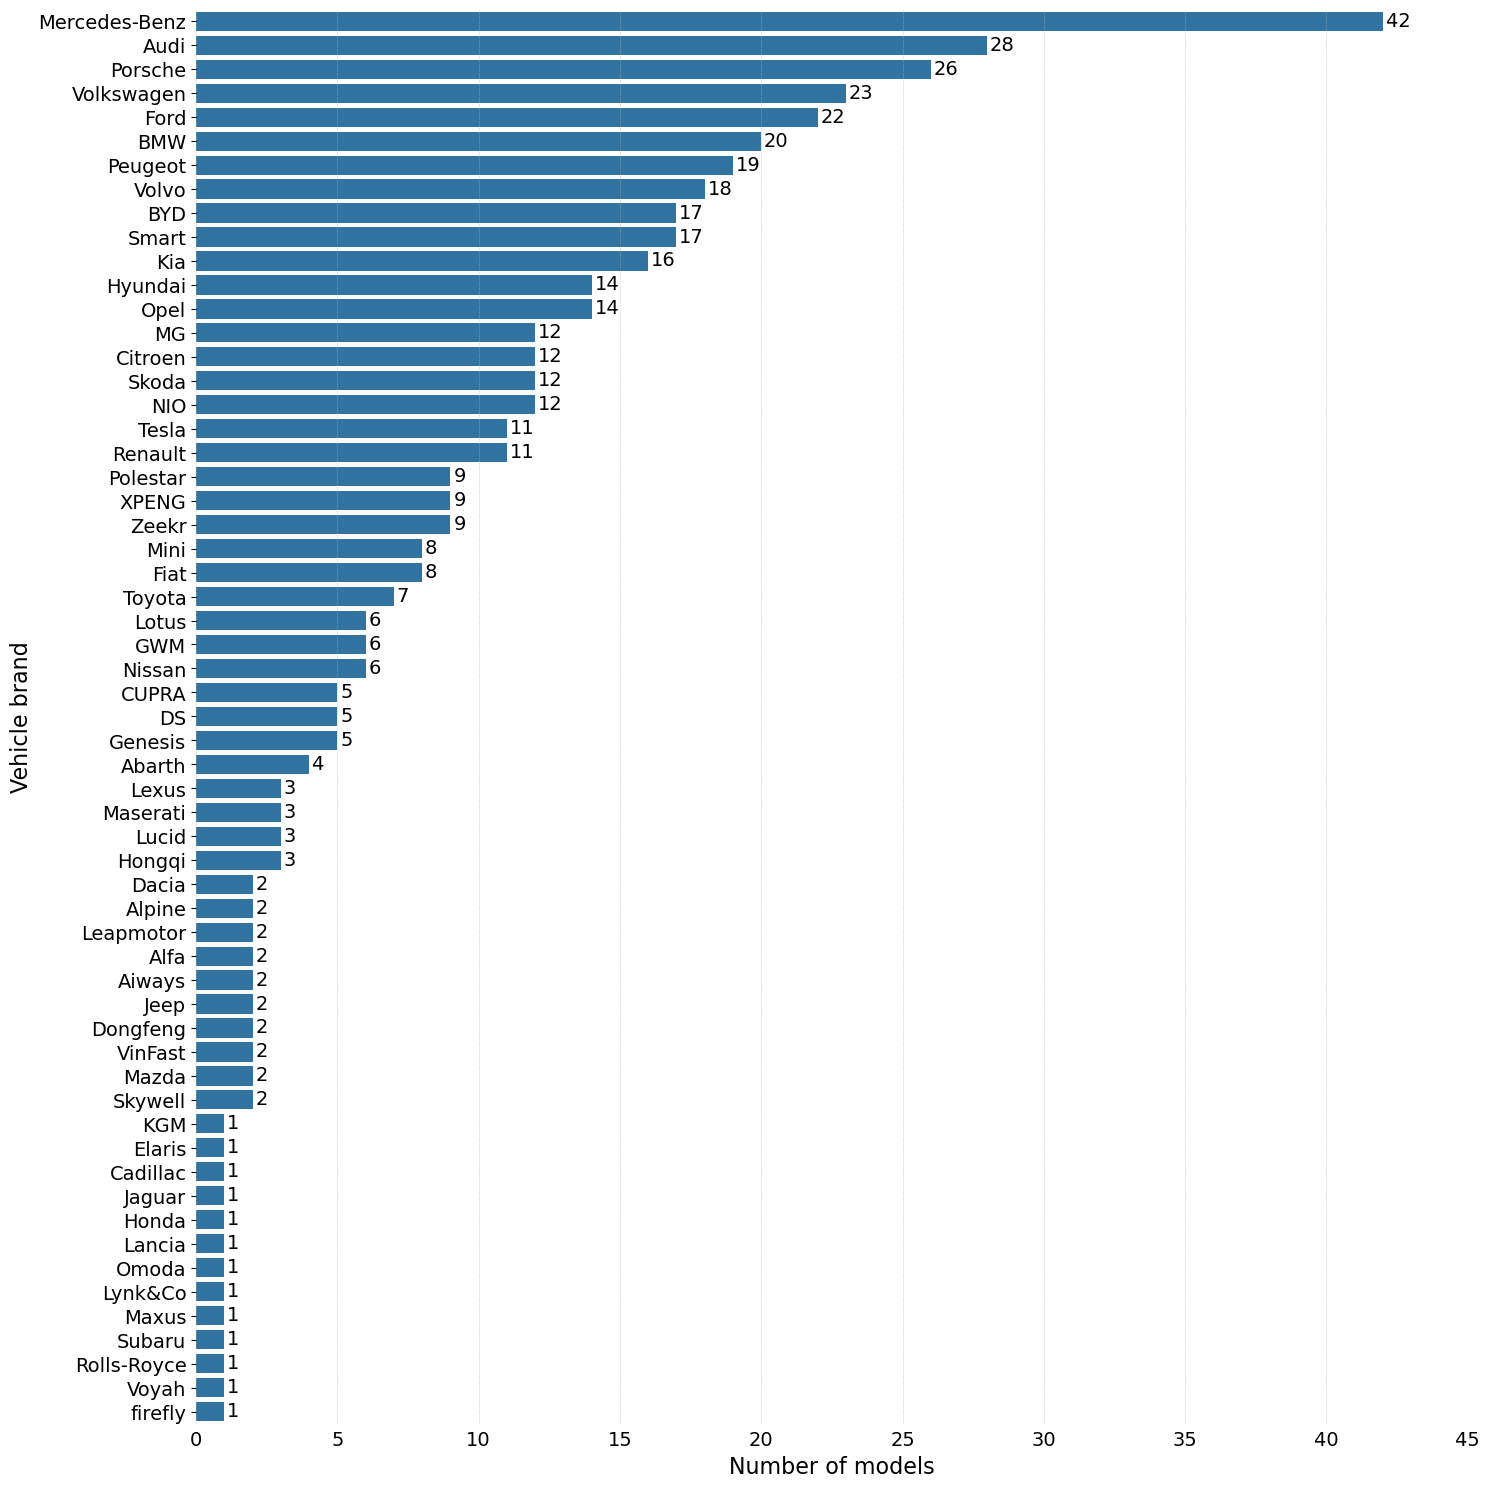

In [12]:
# Prepare the plot
fig, ax = plt.subplots(figsize=(15,15))
sns.barplot(n_model_by_brand,
            y=n_model_by_brand.index,
            x="model", 
            #hue=n_model_by_brand.index,
            orient="h",
            legend=False,
            ax=ax)#, palette=colors)
# Place the count number right next to the bars
for y, model_count in enumerate(n_model_by_brand["model"]):
    # default height of the bar is 0.8, to center the text add 0.2
    # make some space between bar and text, add 0.1
    ax.text(model_count+.1, y+.2, model_count, fontsize=14)
# Name the axes
ax.set_ylabel("Vehicle brand", fontsize=16)
ax.set_xlabel("Number of models", fontsize=16)
ax.set_xticks(np.arange(0,50,5))
ax.set_xticklabels(ax.get_xticks(), fontsize=14)
ax.set_yticks(np.arange(n_model_by_brand.index.shape[0]))
ax.set_yticklabels(n_model_by_brand.index, fontsize=14)
ax.grid(True, linewidth=0.5, linestyle=':', axis="x")
ax.tick_params(axis='x', length=0, pad=5)
# remove the contours
for position in ("top", "right", "left", "bottom"):
    ax.spines[position].set_visible(False)
fig.tight_layout()

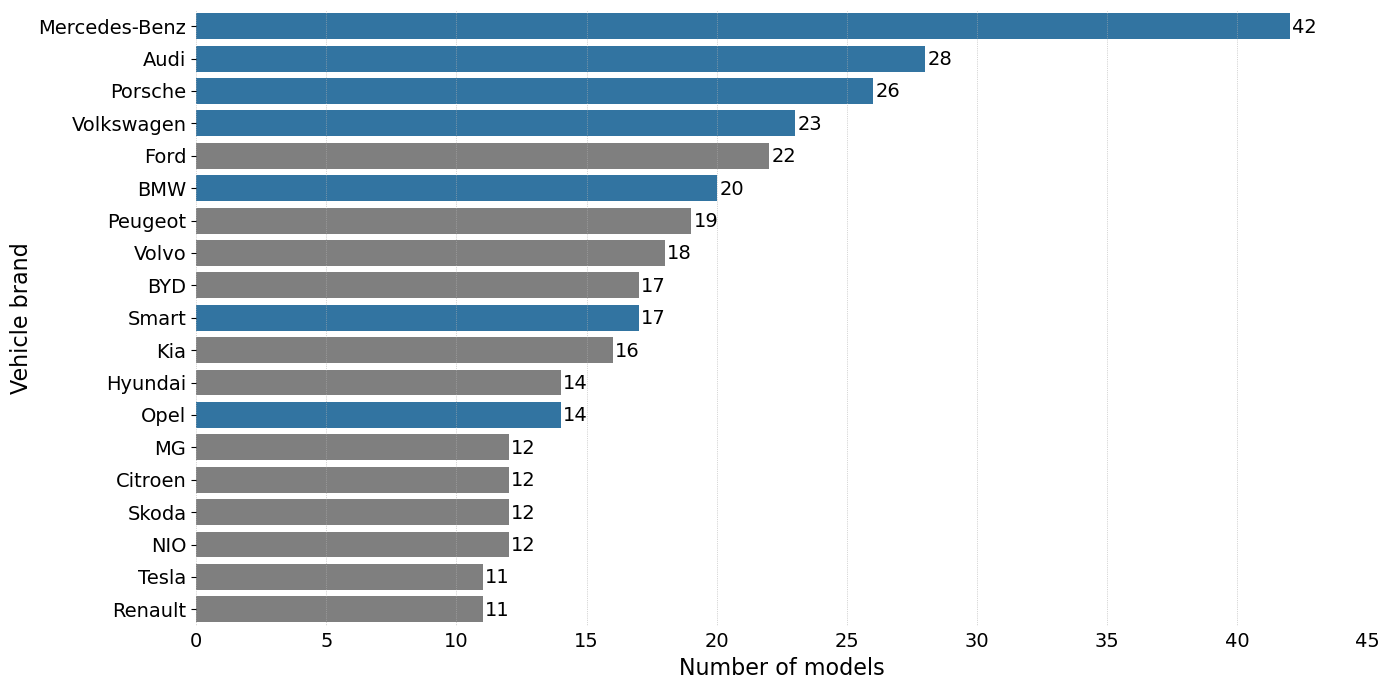

In [13]:
# Show only the brand with 10 or more vehicles
top_brands = n_model_by_brand[n_model_by_brand["model"] >= 10]
# Interesting: which are the brands with the highest number of models. What about German brands?
germany = ["Mercedes-Benz", "Audi", "Porsche", "Volkswagen", "BMW", "Opel", "Smart"]
colors = ["tab:blue" if brand in germany else "tab:gray" for brand in top_brands.index] # use shorter list of brands
# Prepare the plot
fig, ax = plt.subplots(figsize=(14,7))
sns.barplot(top_brands,
            y=top_brands.index,
            x="model", 
            hue=top_brands.index,
            orient="h",
            legend=False,
            ax=ax, palette=colors)
# Place the count number right next to the bars
for y, model_count in enumerate(top_brands["model"]):
    # default height of the bar is 0.8, to center the text add 0.2
    # make some space between bar and text, add 0.1
    ax.text(model_count+.1, y+.2, model_count, fontsize=14)
# Name the axes
ax.set_ylabel("Vehicle brand", fontsize=16)
ax.set_xlabel("Number of models", fontsize=16)
ax.set_xticks(np.arange(0,50,5))
ax.set_xticklabels(ax.get_xticks(), fontsize=14)
ax.set_yticks(np.arange(top_brands.index.shape[0]))
ax.set_yticklabels(top_brands.index, fontsize=14)
ax.grid(True, linewidth=0.5, linestyle=':', axis="x")
ax.tick_params(axis='x', length=0, pad=5)
# remove the contours
for position in ("top", "right", "left", "bottom"):
    ax.spines[position].set_visible(False)
fig.tight_layout()

## 3.2 Features across all vehicles

The goal of this section is to get an overview of the behavior of the featurea across EVs in general.

In [14]:
features = ["range_km", "torque_nm", "top_speed_kmh", "acceleration_0_100_s", "battery_capacity_kWh"]

### 3.2.1 Correlation

In [15]:
corr_matrix = df[features].corr()
corr_matrix = corr_matrix.rename(columns=xlabel_map, index=xlabel_map)
corr_matrix

,Range (km),Torque (Nm),Top Speed (km/h),Acceleration 0-100 km/h (s),Battery Capacity (kWh)
Range (km),1.000000,0.651651,0.732130,-0.712486,0.880433
Torque (Nm),0.651651,1.000000,0.805513,-0.787623,0.756932
Top Speed (km/h),0.732130,0.805513,1.000000,-0.823443,0.708486
Acceleration 0-100 km/h (s),-0.712486,-0.787623,-0.823443,1.000000,-0.643716
Battery Capacity (kWh),0.880433,0.756932,0.708486,-0.643716,1.000000


In [16]:
mask = np.tril(np.ones_like(corr_matrix, dtype=bool),k=-1)
mask

array([[False, False, False, False, False],
       [ True, False, False, False, False],
       [ True,  True, False, False, False],
       [ True,  True,  True, False, False],
       [ True,  True,  True,  True, False]])

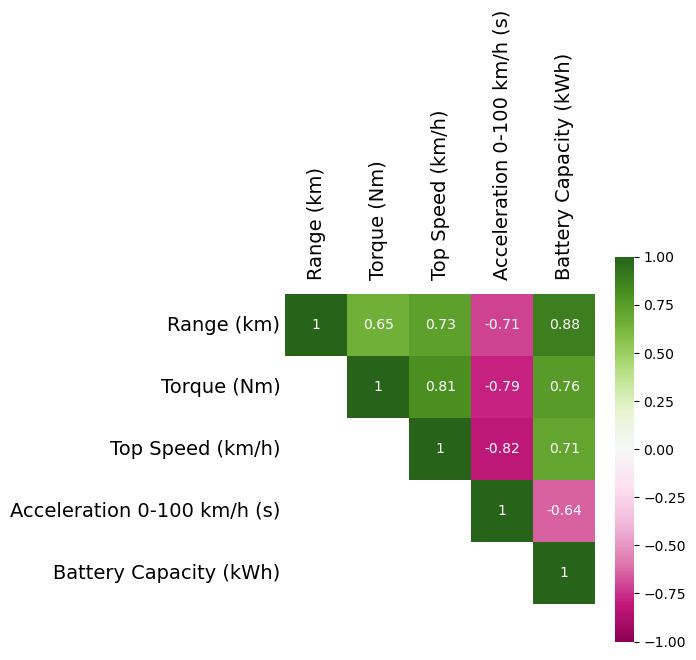

In [17]:
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, center=0, cmap="PiYG", annot=True, square=True)
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.tick_params(axis="both", length=0)
ax.tick_params(axis="x", pad=10)

We observe some strong correlations between the features. Some of them are expected such as _Battery Capacity_ and _Range_, i.e., if the vehicle has a large battery we expect to have a large range. _Torque_ and _Acceleration_ are also strongly negatively correlated, which is also the behavior we would expect, vehicles with high torque are the ones that the need to shortest time to reach 100 km/h.

This initial observations, show clear relationships between certain characteristics. However, the correlation alone does not capture the whole picture, spcial if we include further features like the _Drivetrain_ and _Efficiency_.

We will examine some of this strong correlations in more detail to explore non-linear relationships and how multiple features might interact to influence the performance parameters.

### 3.2.2 Battery capacity and range

We derive the _Efficiency_ of the vehicles as:

$Efficiency = \frac{\text{Range}}{\text{Battery capacity}}$

In [18]:
# calculating efficiency
df['efficiency_km_kWh'] = df['range_km'] / df['battery_capacity_kWh']

In [19]:
# Caclulating the mean battery capacity and range across al vehicles
df.loc[:,["battery_capacity_kWh", "range_km", "efficiency_km_kWh"]].describe().T.rename(index=xlabel_map).apply(round, args=(2,))

,count,mean,std,min,25%,50%,75%,max
Battery Capacity (kWh),478.0,74.04,20.33,21.3,60.00,76.15,90.60,118.00
Range (km),478.0,393.18,103.29,135.0,320.00,397.50,470.00,685.00
Efficiency (km/kWh),478.0,5.38,0.71,3.1,4.94,5.43,5.91,7.36


We also examine the skewness of these three feature to get a sense of the symetry of the distributions.

In [20]:
df.loc[:,["battery_capacity_kWh", "range_km", "efficiency_km_kWh"]].skew().apply(round, args=(2,))

battery_capacity_kWh   -0.11
range_km               -0.16
efficiency_km_kWh      -0.45
dtype: float64

In [21]:
mean_range = df.range_km.mean()
mean_battery_capacity = df.battery_capacity_kWh.mean()
mean_efficiency = df.efficiency_km_kWh.mean()

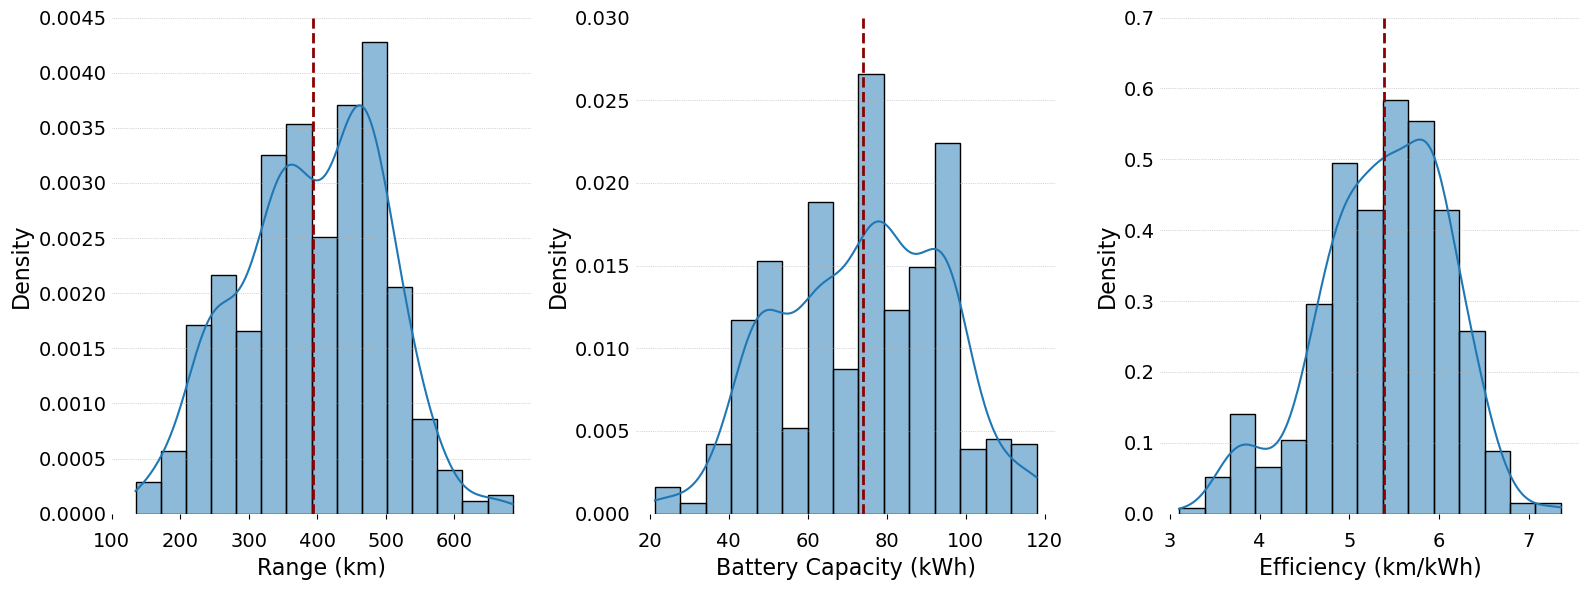

In [22]:
# figure and axs
fig, axs = plt.subplots(figsize=(16,6), nrows=1, ncols=3)
# distribution of the range
sns.histplot(df, x="range_km", bins=15, kde=True, stat="density", alpha=0.5, ax=axs[0])
# ranges must be set separately for each plot
axs[0].set_xticks(np.arange(100,700,100), np.arange(100,700,100))
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=14)
axs[0].axvline(mean_range, color='darkred', linestyle='--', linewidth=2)
#axs[0].text(x=mean_range+10, y=axs[0].get_ylim()[1], s=f"Mean = {mean_range:.1f}km", fontsize=14)

#distribution of the battery capacity
sns.histplot(df, x="battery_capacity_kWh", bins=15, kde=True, stat="density", ax=axs[1])
axs[1].set_xticks(np.arange(20,130,20), np.arange(20,130,20))
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=14)
axs[1].axvline(mean_battery_capacity, color='darkred', linestyle='--', linewidth=2)
#axs[1].text(x=mean_battery_capacity+2, y=axs[1].get_ylim()[1]*1.07, s=f"Mean = {mean_battery_capacity:.1f}kWh", fontsize=14)

# distribution of the efficiency
sns.histplot(df, x="efficiency_km_kWh", bins=15, kde=True, stat="density", ax=axs[2])
axs[2].set_xticks(np.arange(3,8,1))
axs[2].set_xticklabels(axs[2].get_xticklabels(), fontsize=14)
axs[2].axvline(mean_efficiency, color='darkred', linestyle='--', linewidth=2)
#axs[2].text(x=mean_efficiency+.1, y=axs[2].get_ylim()[1]*1.14, s=f"Mean = {mean_efficiency:.1f}km/kWh", fontsize=14)

# Editing the plots 
for ax in axs:#.flatten():
    ax.grid(True, linewidth=0.5, linestyle=':', axis="y")
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel(xlabel_map.get(ax.get_xlabel(), ""), fontsize=16) # Use the get method to avoid a KeyError when looping over last plot
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.tick_params(axis="y", length=0)
    ax.tick_params(axis="x", pad=10)


fig.tight_layout()

From the distributions we observe:

1. Mean Battery Capacity = 74.0 kWh; Mean range = 393.2 km; Mean efficiency = 5.4 km/kWh
2. The low values of skewness confirm that the distributions are approximately symmetric (-0.5, 0.5)

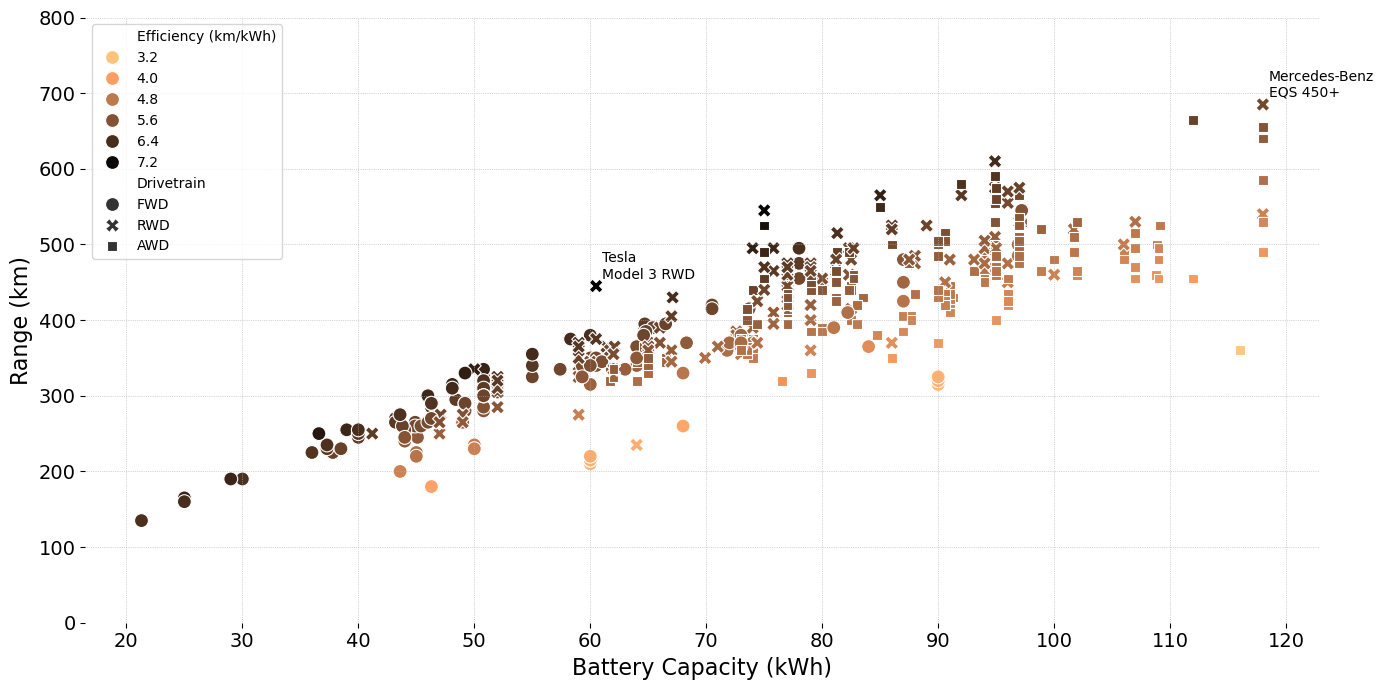

In [23]:
# Create figure
fig, ax = plt.subplots(figsize=(14,7))
# Battery capcity and Range
sns.scatterplot(df.rename(columns=xlabel_map),
                x=xlabel_map.get("battery_capacity_kWh"),
                y=xlabel_map.get("range_km"),
                style=xlabel_map.get("drivetrain"),
                hue=xlabel_map.get("efficiency_km_kWh"),
                s=100,
                palette="copper_r",
                ax=ax)

# Edit the plot
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax.grid(True, linewidth=0.5, linestyle=":")
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.set_xticks(np.arange(20,130,10))
ax.set_xticklabels(ax.get_xticks(), fontsize=14)
ax.set_yticks(np.arange(0,900,100))
ax.set_yticklabels(ax.get_yticks(), fontsize=14)


# Get the vehicle with the highest battery and range - middle efficiency
highest_range = df[(df["drivetrain"]=="RWD") & (df["range_km"]>650)]
highest_range = highest_range[["brand", "model", "battery_capacity_kWh", "range_km", "efficiency_km_kWh"]]

ax.text(highest_range["battery_capacity_kWh"].iloc[0] + .5,
        highest_range["range_km"].iloc[0] + 10,
        f"{highest_range['brand'].iloc[0]}\n{highest_range['model'].iloc[0]}", fontsize=10)

# Get the vehicle with half of the battery size and range - high efficiency
high_efficiency = df[(df["drivetrain"]=="RWD") & (df["battery_capacity_kWh"].between(60, 65)) & (df["range_km"].between(400, 450))]
high_efficiency = high_efficiency[["brand", "model", "battery_capacity_kWh", "range_km", "efficiency_km_kWh"]]

ax.text(high_efficiency["battery_capacity_kWh"].iloc[0]+0.5,
        high_efficiency["range_km"].iloc[0] + 10,
        f"{high_efficiency['brand'].iloc[0]}\n{high_efficiency['model'].iloc[0][:12]}", fontsize=10)

fig.tight_layout()

1. The scatter plot shows a positive correlation between battery capacity and range, i.e., range tends to increase as the battery capacity increases.
2. _FWD_ vehicles tend to have lower values for _Range_ compared to _RWD_ and _AWD_, with more _AWD_ vehicles on the higher end of the _Range_.
3. The plot also shows that vehicles with higher efficiency tend to have smaller batteries. An example of this, are the _Mercedes-Benz EQS 450+_ and the _Tesla Model 3_ as shown in the table below:

In [24]:
pd.concat([highest_range, high_efficiency], axis=0).rename(columns=xlabel_map)

,brand,model,Battery Capacity (kWh),Range (km),Efficiency (km/kWh)
239,Mercedes-Benz,EQS 450+,118.0,685,5.805085
400,Tesla,Model 3 RWD (Highland CATL LFP64),60.5,445,7.355372


In [25]:
df.loc[:,["battery_capacity_kWh", "range_km", "efficiency_km_kWh"]].corr().rename(columns=xlabel_map, index=xlabel_map)

,Battery Capacity (kWh),Range (km),Efficiency (km/kWh)
Battery Capacity (kWh),1.000000,0.880433,-0.358073
Range (km),0.880433,1.000000,0.105861
Efficiency (km/kWh),-0.358073,0.105861,1.000000


We can conclude that Battery Capacity is strongly correlated with Range but not with Efficiency. In fact, as shown in the plot above, the most efficient EVs are the ones with the smaller batteries, suggesting that Battery size does not play a crucial role in achieving high efficiency.

### 3.2.3 Torque, Acceleration and Top Speed

At the begining of the analysis, we detected 7 missing torque values. Since we are not doing predictive modeling, we can opt for simplicity and drop these rows.

In [26]:
df[df["torque_nm"].isnull()]

,brand,model,top_speed_kmh,battery_capacity_kWh,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,efficiency_km_kWh
61,BYD,DOLPHIN 44.9 kWh Boost,160,44.9,NaN,145,260,8.0,50.0,0.0,345,5,FWD,C - Medium,4290,1770,1570,Hatchback,5.790646
195,Lucid,Air Pure RWD,200,92.0,NaN,130,565,4.7,160.0,0.0,456,5,RWD,F - Luxury,4975,1939,1410,Sedan,6.141304
196,Lucid,Air Touring,250,92.0,NaN,142,580,3.2,160.0,0.0,456,5,AWD,F - Luxury,4975,1939,1410,Sedan,6.304348
401,Tesla,Model S Dual Motor,250,95.0,NaN,150,575,3.2,140.0,1600.0,709,5,AWD,F - Luxury,5021,1987,1431,Liftback Sedan,6.052632
402,Tesla,Model S Plaid,282,95.0,NaN,158,560,2.3,140.0,1600.0,709,5,AWD,F - Luxury,5021,1987,1431,Liftback Sedan,5.894737
403,Tesla,Model X Dual Motor,250,95.0,NaN,165,485,3.9,140.0,2250.0,425,7,AWD,JF - Luxury,5057,1999,1680,SUV,5.105263
404,Tesla,Model X Plaid,262,95.0,NaN,180,465,2.7,140.0,2250.0,425,7,AWD,JF - Luxury,5057,1999,1680,SUV,4.894737


In [27]:
df_torque = df.dropna(subset="torque_nm")

In [28]:
# Caclulating the mean battery capacity and range across al vehicles
df_torque.loc[:,["torque_nm", "top_speed_kmh", "acceleration_0_100_s"]].describe().T.rename(index=xlabel_map)

,count,mean,std,min,25%,50%,75%,max
Torque (Nm),471.0,498.012739,241.461128,113.0,305.0,430.0,679.0,1350.0
Top Speed (km/h),471.0,184.732484,33.607822,125.0,160.0,180.0,201.0,325.0
Acceleration 0-100 km/h (s),471.0,6.925478,2.719298,2.2,4.8,6.6,8.3,19.1


In [29]:
df_torque.loc[:,["torque_nm", "top_speed_kmh", "acceleration_0_100_s"]].skew().apply(round, args=(2,))

torque_nm               0.83
top_speed_kmh           0.64
acceleration_0_100_s    0.89
dtype: float64

In [30]:
mean_top_speed = df_torque.top_speed_kmh.mean()
mean_torque = df_torque.torque_nm.mean()
mean_acceleration = df_torque.acceleration_0_100_s.mean()

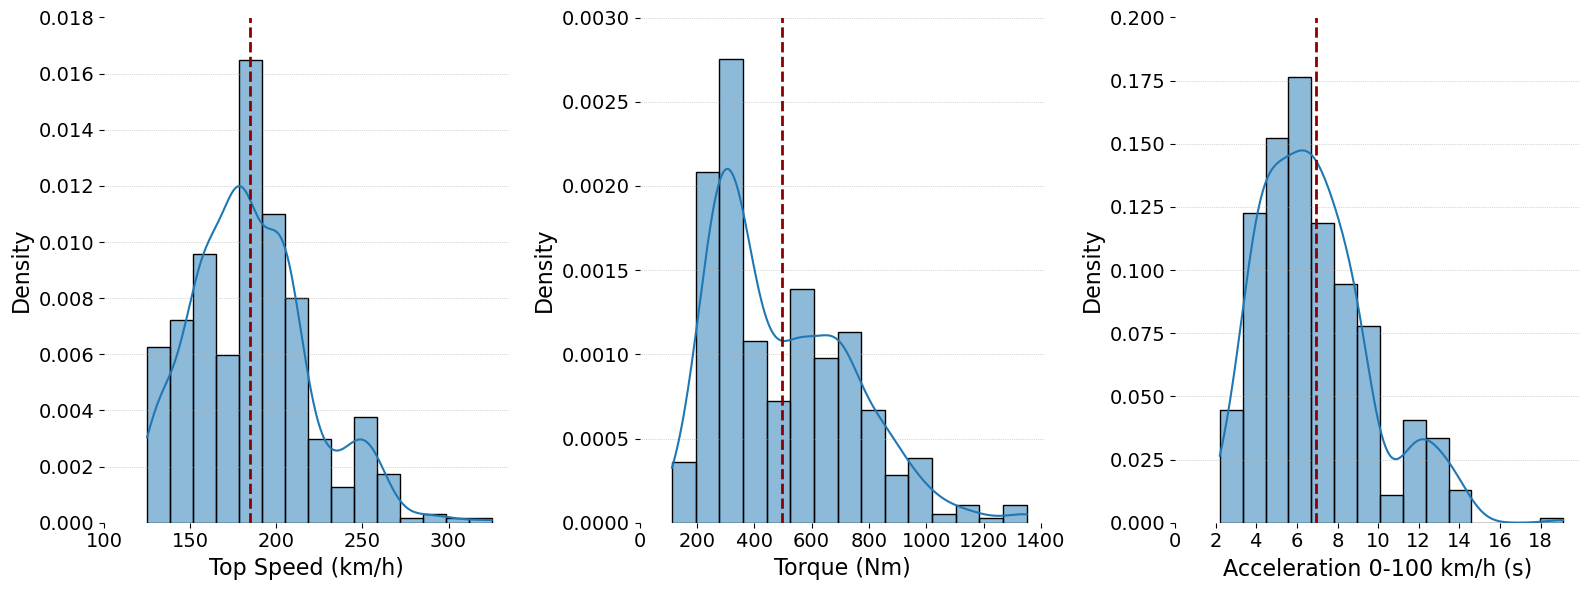

In [31]:
# figure and axs
fig, axs = plt.subplots(figsize=(16,6), nrows=1, ncols=3)
# distribution of top speed
sns.histplot(df, x="top_speed_kmh", bins=15, kde=True, stat="density", ax=axs[0])
# ranges must be set separately for each plot
axs[0].set_xticks(np.arange(100,350,50), np.arange(100,350,50))
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=14)
axs[0].axvline(mean_top_speed, color='darkred', linestyle='--', linewidth=2)
#axs[0].text(x=mean_top_speed + 6, y=axs[0].get_ylim()[1], s=f"Mean = {mean_top_speed:.1f}km/h", fontsize=14)

# distribution of torque
sns.histplot(df, x="torque_nm", bins=15, kde=True, stat="density", ax=axs[1])
axs[1].set_xticks(np.arange(0,1600,200), np.arange(0,1600, 200))
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=14)
axs[1].axvline(mean_torque, color='darkred', linestyle='--', linewidth=2)
#axs[1].text(x=mean_torque + 40, y=axs[1].get_ylim()[1], s=f"Mean = {mean_torque:.1f}Nm", fontsize=14)

# distribution of acceleration
sns.histplot(df, x="acceleration_0_100_s", bins=15, kde=True, stat="density", ax=axs[2])
axs[2].set_xticks(np.arange(0,20,2), np.arange(0,20,2))
axs[2].set_xticklabels(axs[2].get_xticklabels(), fontsize=14)
axs[2].axvline(mean_acceleration, color='darkred', linestyle='--', linewidth=2)
#axs[2].text(x=mean_acceleration+.5, y=axs[2].get_ylim()[1]*1.04, s=f"Mean = {mean_acceleration:.1f}km", fontsize=14)

# Editing the plots 
for ax in axs:
    ax.grid(True, linewidth=0.5, linestyle=':', axis="y")
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel(xlabel_map.get(ax.get_xlabel(), ""), fontsize=16) # Use the get method to avoid a KeyError when looping over last plot
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)

fig.tight_layout()

In [32]:
df.loc[:,["top_speed_kmh", "torque_nm", "acceleration_0_100_s"]].describe().T.apply(round, args=(2,))

,count,mean,std,min,25%,50%,75%,max
top_speed_kmh,478.0,185.49,34.25,125.0,160.0,180.0,201.0,325.0
torque_nm,471.0,498.01,241.46,113.0,305.0,430.0,679.0,1350.0
acceleration_0_100_s,478.0,6.88,2.73,2.2,4.8,6.6,8.2,19.1


In [33]:
# Function to model the behavior of torque vs acceleration and Acceleration and speed
def decay(x, a, b, c):
    """Exponential decay"""
    return a * np.exp(-b*x) + c

# Function to evaluate the behvior of torque and top speed
def grow(x, a, r):
    """Exponential growth"""
    return a * ((1 + r) ** x)

In [34]:
# Fitting a linear regresion for torque and speed
lr = LinearRegression()
lr.fit(df_torque.loc[:,["torque_nm"]], df_torque.loc[:,"top_speed_kmh"])

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [35]:
print(f"Slope = {lr.coef_}\nIntercept = {lr.intercept_}")

Slope = [0.11211556]
Intercept = 128.8975077491307


In [36]:
# Extract the values for curve fitting
torque = df_torque["torque_nm"].values
acceleration = df_torque["acceleration_0_100_s"].values
top_speed = df_torque["top_speed_kmh"].values

In [37]:
# Parameters for torque vs acceleration
# X data to plot the line
xaxis1 = np.arange(100,1500,100)
popt_torque_acceleration, pcov = curve_fit(decay, xdata=torque, ydata=acceleration, p0=(20.0,0.0001,2.0))
# Parameters for torque vs top_speed
xaxis2 = pd.DataFrame(np.arange(150,1500,100), columns=["torque_nm"])
popt_torque_speed, pcov = curve_fit(grow, xdata=torque, ydata=top_speed, p0=(120,.005))
# Parameters for acceleration speed
xaxis3 = np.arange(2,20,1)
popt_acceleration_speed, pcov = curve_fit(decay, xdata=acceleration, ydata=top_speed, p0=(325.0,0.01,120.0))

In [38]:
# Parameters for torque acceleration
for param, value in zip(("a", "b", "c"), popt_torque_acceleration):
    print(f"{param} = {value:.4f}")

a = 14.8429
b = 0.0032
c = 3.1196


In [39]:
linear_r2 = r2_score(top_speed, lr.predict(df_torque[["torque_nm"]]))
r2_linear_fit = round(linear_r2, 3)

exp_growth_r2 = r2_score(top_speed, grow(df_torque[["torque_nm"]], *popt_torque_speed))
r2_nonlinear_fit = round(exp_growth_r2, 3)

print(f"R2 score for the linear function = {r2_linear_fit}\nR2 score for the non-linear function = {r2_nonlinear_fit}")

R2 score for the linear function = 0.649
R2 score for the non-linear function = 0.639


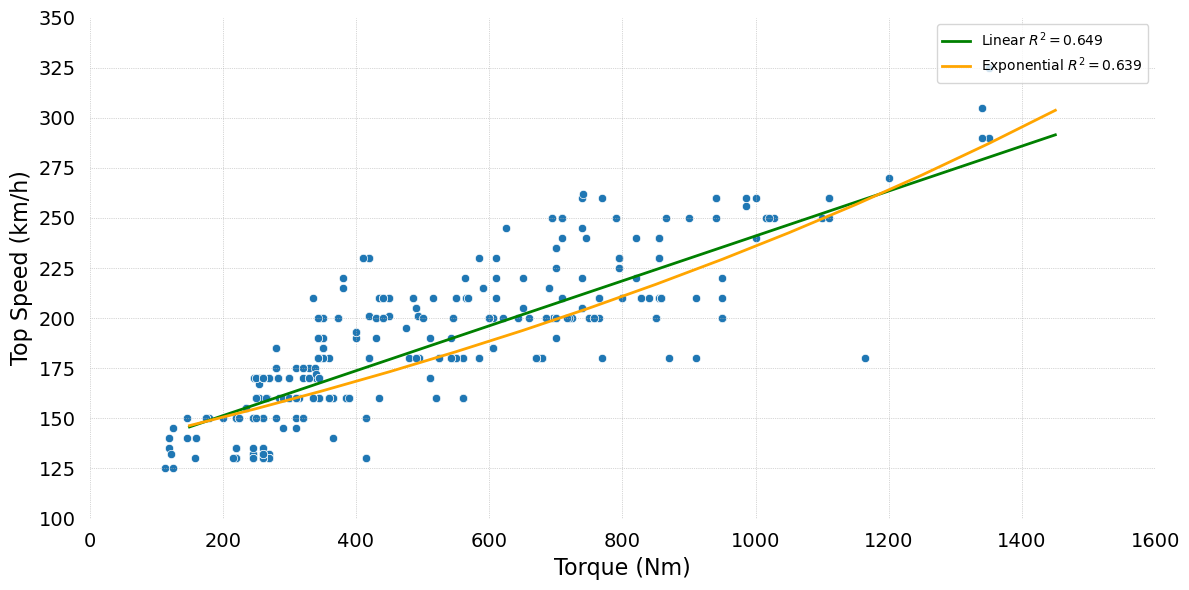

In [40]:
fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=1)
# Torque vs top speed
sns.scatterplot(df_torque,
                x="torque_nm",
                y="top_speed_kmh",
                ax=ax)

# Plot the linear regresion for comparison
ax.plot(xaxis2, lr.predict(xaxis2), color="green", linewidth=2, label="Linear $R^2 = 0.649$")
# Plot exponential function
ax.plot(xaxis2, grow(xaxis1, *popt_torque_speed), color="orange", linewidth=2, label="Exponential $R^2 = 0.639$")

# Editing the plot
ax.grid(True, linewidth=0.5, linestyle=':')
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel(xlabel_map.get(ax.get_xlabel(), ""), fontsize=16) # Use the get method to avoid a KeyError when looping over last plot
ax.set_ylabel(xlabel_map.get(ax.get_ylabel(), ""), fontsize=16)
ax.tick_params(axis="both", length=0, pad=10)
ax.legend(loc="upper right")
fig.tight_layout()

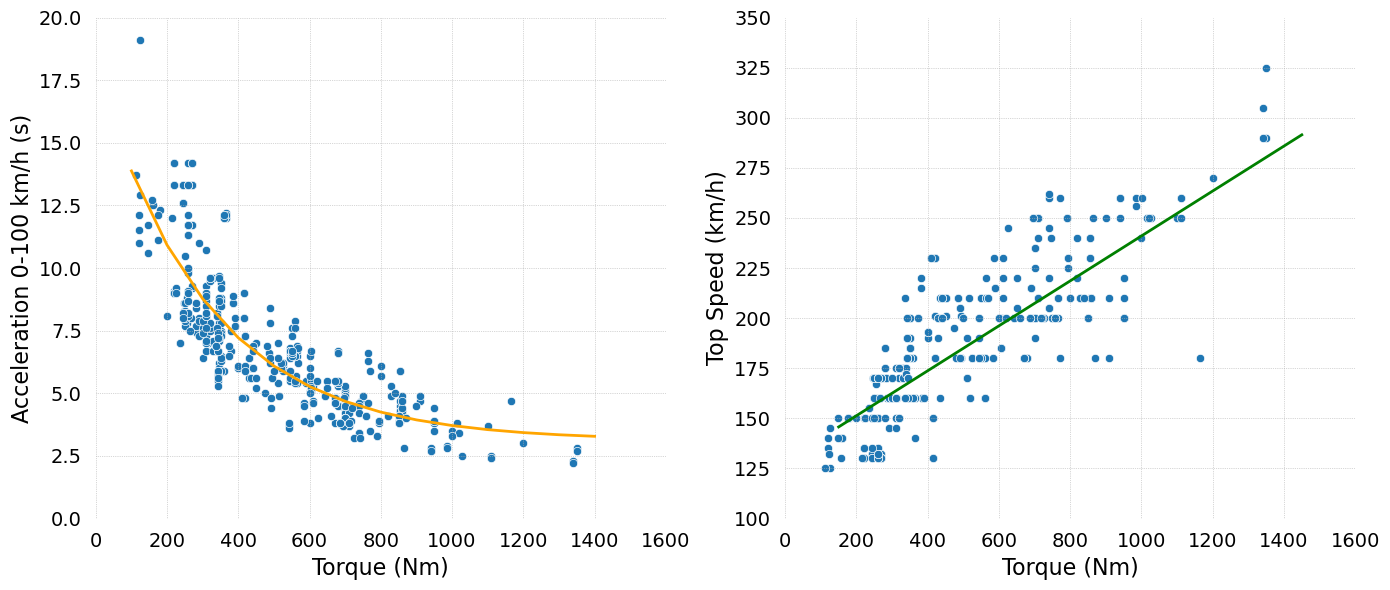

In [41]:
fig, axs = plt.subplots(figsize=(14,6), nrows=1, ncols=2)
# Torque vs acceleration
sns.scatterplot(df_torque,
                x="torque_nm",
                y="acceleration_0_100_s",
                ax=axs[0])
# Plot the fitted curve
axs[0].plot(xaxis1, decay(xaxis1, *popt_torque_acceleration), color="orange", linewidth=2)

# Torque vs top speed
sns.scatterplot(df_torque,
                x="torque_nm",
                y="top_speed_kmh",
                ax=axs[1])
# Plot the linear regresion for comparison
axs[1].plot(xaxis2, lr.predict(xaxis2), color="green", linewidth=2)

# Editing the plots 
for ax in axs:
    ax.grid(True, linewidth=0.5, linestyle=':')
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel(xlabel_map.get(ax.get_xlabel(), ""), fontsize=16) # Use the get method to avoid a KeyError when looping over last plot
    ax.set_ylabel(xlabel_map.get(ax.get_ylabel(), ""), fontsize=16)
    ax.tick_params(axis="both", length=0, pad=10)

fig.tight_layout()

In [42]:
(df_torque.loc[:,["torque_nm", "acceleration_0_100_s", "top_speed_kmh"]]
    .corr()
    .rename(columns=xlabel_map, index=xlabel_map)
    .apply(round, args=(2,)))

,Torque (Nm),Acceleration 0-100 km/h (s),Top Speed (km/h)
Torque (Nm),1.00,-0.79,0.81
Acceleration 0-100 km/h (s),-0.79,1.00,-0.82
Top Speed (km/h),0.81,-0.82,1.00


The relationship between _Torque_ and _Acceleration_ aligns with the physical intuition: vehicles with higher torque tend to accelerate faster, resulting in lower acceleration times. This can be also observed in the correlogram, which shows a relatively strong negative correlation of -0.79. However, despite this strong correlation, the scatter plot reveals a clear non-linear trend, suggesting that a simple linear model does not properly capture the relationship between these two features.

The data appears to follow an exponential decay, where increases in torque lead to progressively smaller improvements in acceleration time. This implies that while increasing torque does reduce the time to reach 100 km/h, smaller improvements are obtained after a certain point, i.e., additional torque yields only minimal acceleration increases.

The correlogram also shows a strong positive correlation value of 0.81 between _Torque_ and _Top speed_. Initially, this scatter plot suggested a non-linear relationship, as it was in the previous case. However, further anaylsis revealed that the features are better explained by a linear model, as supported by the slightly higher $R^2$ value (0.649) compared to the exponential growth (0.639). This finding suggests that vehicles with high torque will tend to have higher values of top speed.

In summary, vehicles with more torque not only accelerate faster but also tend to reach higher top speeds. The fact that torque is tied to both acceleration and top speed supports the idea that it is a key indicator of overall performance.

# 4. Analysis by segment

## 4.1 Definition of vehicle segments

The segements contained in the dataset are divided in two big groups:

1. With prefix "J"
2. With no prefix

The "J" stands for sport utility cars, the second letter indicates the segmentation according to _Case No COMP/M.1406 Hyundai / Kia Regulation (EEC) No 4064/89 Merger Procedure_ for both groups.

In [43]:
# Segments starting with J refer to SUVs
# So two major classifications can be performed SUV and not SUVs
df[df["car_body_type"] == "SUV"]['segment'].str.startswith("J").all()

np.True_

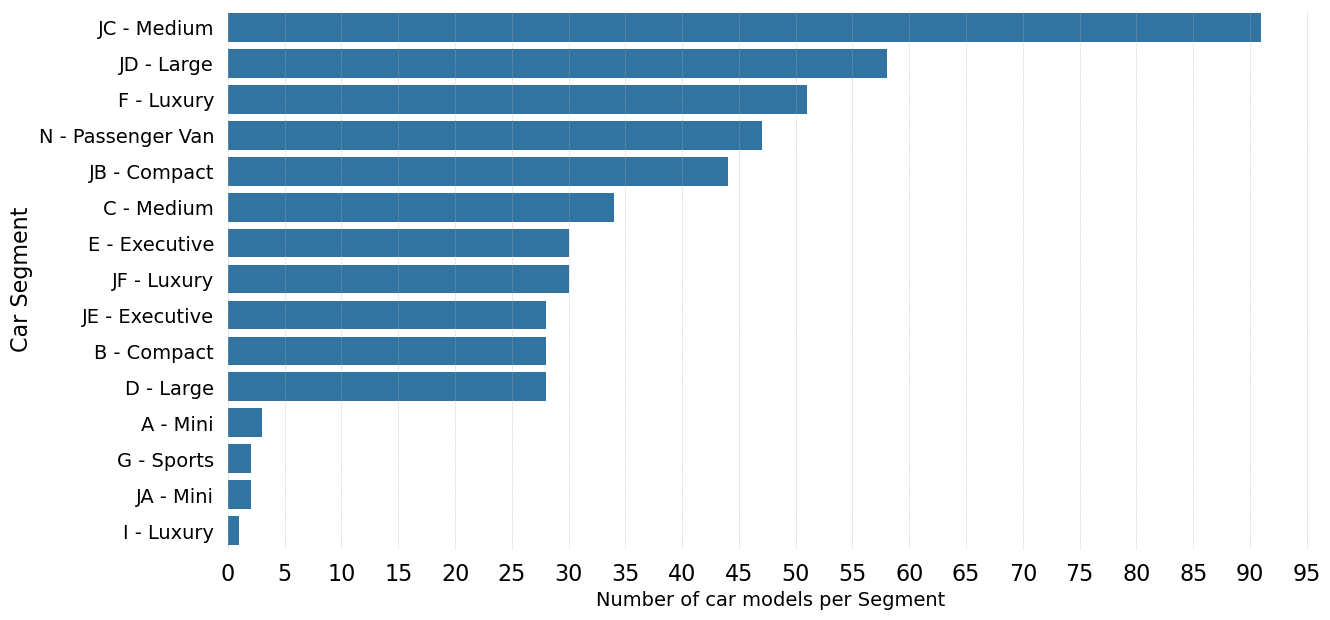

In [44]:
# According to Case No COMP/M.1406 Hyundai / Kia Regulation (EEC) No 4064/89 Merger Procedure
models_by_segment = df.groupby("segment")["model"].count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(14,7))
sns.barplot(models_by_segment, orient="h", ax=ax)
ax.grid(True, linewidth=0.5, linestyle=":", axis="x")
ax.set_xticks(np.arange(0,100,5))
ax.set_xticklabels(ax.get_xticks(), fontsize=16)
ax.set_ylabel("Car Segment", fontsize=16)
ax.set_yticks(np.arange(models_by_segment.index.shape[0]))
ax.set_yticklabels(models_by_segment.index, fontsize=14)
ax.set_xlabel("Number of car models per Segment", fontsize=14)
ax.spines[["top", "right", "left", "bottom"]].set_visible(False)
ax.tick_params(axis="both", length=0, pad=10)

In [45]:
# With the original segments
metrics = df.groupby("segment")[["range_km", "torque_nm", "top_speed_kmh", "acceleration_0_100_s", "battery_capacity_kWh"]].agg(["mean", "median", "skew"])
metrics = metrics.stack(1, future_stack=True)

def highlight_selected(row):
    if row.name[1] == "mean":
        return ["background-color: #f9cb9c"] * len(row)
    return [""] * len(row)

metrics.style.apply(highlight_selected, axis=1)

Some of the segments contained in the data set include only a few cars. In this case, the calculated statistics will not be representative, since segments with 1-3 cars can skew the mean with just one extrem value. To address this issues, the segments will be merged into broader groups that are also contextually related, this with the goal of increasing sample sizes and thus potentially improving the descriptive statistcs.

Another issue that will be addressed with these broader groups is the fact that the visualizations can become cluttered and difficult to interpret.

The trade-off of this approach, as mentioned before is taht the means of the new groups could be pulled towards the outliers.

In [46]:
new_segment_categories = {
    'A - Mini': 'Mini & Compact',
    'JA - Mini': 'Mini & Compact',
    'B - Compact': 'Mini & Compact',
    'JB - Compact': 'Mini & Compact',
    'C - Medium': 'Medium',
    'JC - Medium': 'Medium',
    'D - Large': 'Large & Executive',
    'E - Executive': 'Large & Executive',
    'JD - Large': 'Large & Executive',
    'JE - Executive': 'Large & Executive',
    'F - Luxury': 'Luxury & Sports',
    'I - Luxury': 'Luxury & Sports',
    'JF - Luxury': 'Luxury & Sports',
    'G - Sports': 'Luxury & Sports',
    'N - Passenger Van': 'Passenger Van'
}

In [47]:
df.loc[:, ["new_segment"]] = df["segment"].map(new_segment_categories)
df_torque.loc[:, ["new_segment"]] = df_torque["segment"].map(new_segment_categories)

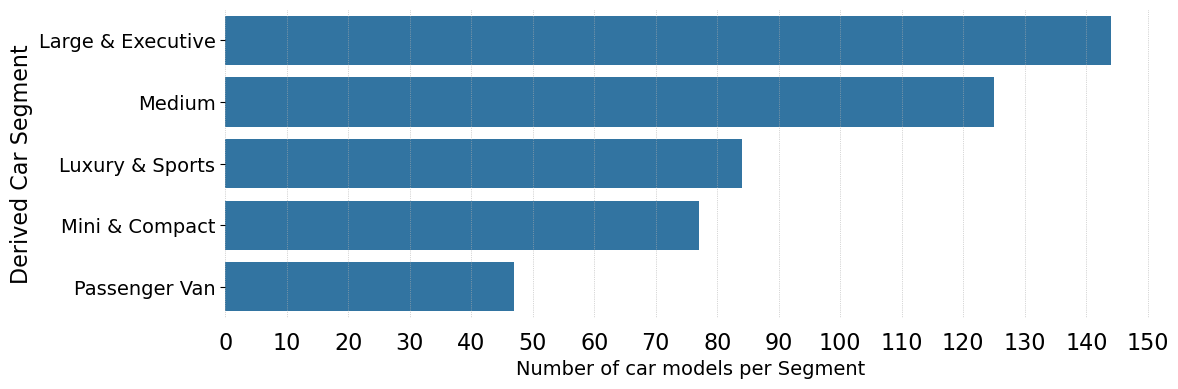

In [48]:
models_by_new_segment = df.groupby("new_segment")["model"].count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(models_by_new_segment, orient="h", ax=ax)
ax.grid(True, linewidth=0.5, linestyle=":", axis="x")
ax.set_xticks(np.arange(0,155,10))
ax.set_xticklabels(ax.get_xticks(), fontsize=16)
ax.set_ylabel("Derived Car Segment", fontsize=16)
ax.set_yticks(np.arange(models_by_new_segment.index.shape[0]))
ax.set_yticklabels(models_by_new_segment.index, fontsize=14)
ax.set_xlabel("Number of car models per Segment", fontsize=14)
ax.spines[["top", "right", "left", "bottom"]].set_visible(False)
ax.tick_params(axis="x", length=0, pad=10)

In [49]:
# With the new segments
metrics_new_segment = df.groupby("new_segment")[["range_km", "torque_nm", "top_speed_kmh", "acceleration_0_100_s", "battery_capacity_kWh"]].agg(["mean", "std", "median", "skew"])
metrics_new_segment = metrics_new_segment.loc[segment_order, :]
metrics_new_segment = metrics_new_segment.stack(1, future_stack=True).apply(round, args=(2,))
metrics_new_segment.style.apply(highlight_selected, axis=1)

### 4.2 Features by segment

Now, we examine the difference between the different segments according some important features of the EVs.

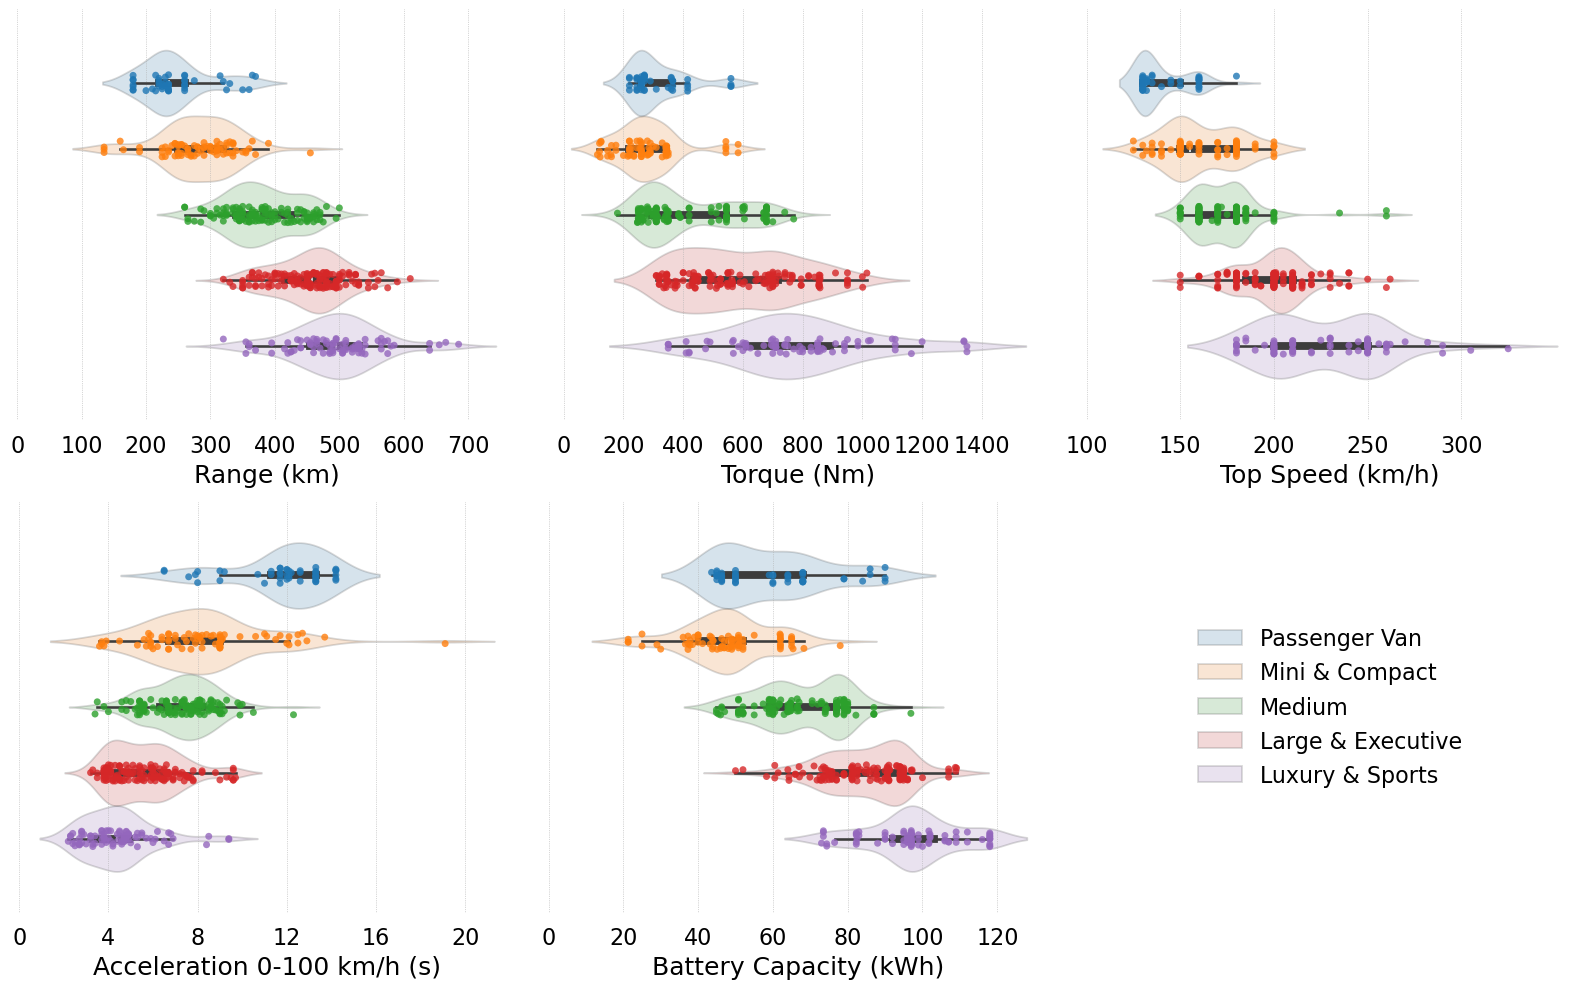

In [50]:
# Create the figure
fig, axs = plt.subplots(figsize=(16,10), nrows=2, ncols=3)
# Create violinplots
handles, labels = None, None
for ax, metric in zip(axs.flatten(), metrics_new_segment.columns):
    sns.stripplot(df,
                  x=metric,
                  hue="new_segment",
                  hue_order=segment_order,
                  palette=segment_palette,
                  jitter=True,
                  dodge=True,
                  size=5,
                  alpha=0.8,
                  ax=ax)
    sns.violinplot(df,
                   x=metric,
                   hue="new_segment",
                   hue_order=segment_order,
                   palette=segment_palette,
                   alpha=0.2,
                   ax=ax)
    ax.set_xlabel(xlabel_map[metric], fontsize=18)
    ax.set_ylabel("", fontsize=16)
    ax.set_yticks([])
    ax.grid(True, linewidth=0.5, linestyle=':', axis="x")
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)

    if handles is None:
        h, l = ax.get_legend_handles_labels()
        by_label = dict(zip(l, h))
        labels  = list(by_label.keys())
        handles = [by_label[k] for k in labels]
    ax.legend_.remove()
    ax.tick_params(axis="x", length=0, pad=10)
# Handle y axis separately to select a better range for the values
# Range
axs[0,0].set_xticks(np.arange(0,800,100), np.arange(0,800,100))
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), fontsize=16)

# Torque
axs[0,1].set_xticks(np.arange(0,1600,200), np.arange(0,1600,200))
axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), fontsize=16)

# Speed
axs[0,2].set_xticks(np.arange(100,350,50), np.arange(100,350,50))
axs[0,2].set_xticklabels(axs[0,2].get_xticklabels(), fontsize=16)

# Acceleration
axs[1,0].set_xticks(np.arange(0,24,4), np.arange(0,24,4))
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), fontsize=16)

# Battery Capacity
axs[1,1].set_xticks(np.arange(00,130,20), np.arange(0,130,20))
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), fontsize=16)

axs[1,2].axis("off")
axs[1,2].legend(handles, labels, loc="center", fontsize=16, frameon=False, title=None)

fig.tight_layout(rect=[0, 0, 1, 1])

In [51]:
(df[df["new_segment"]=="Luxury & Sports"]
    .loc[:,["brand", "model", 
            "range_km", "torque_nm", "top_speed_kmh", "acceleration_0_100_s", "battery_capacity_kWh", "fast_charging_power_kw_dc"]]
    .sort_values(by=["top_speed_kmh", "acceleration_0_100_s"], ascending=False).head(3))

,brand,model,range_km,torque_nm,top_speed_kmh,acceleration_0_100_s,battery_capacity_kWh,fast_charging_power_kw_dc
211,Maserati,GranTurismo Folgore,420,1350.0,325,2.7,83.0,217.0
348,Porsche,Taycan Turbo GT Weissach,475,1340.0,305,2.2,97.0,281.0
210,Maserati,GranCabrio Folgore,395,1350.0,290,2.8,83.0,190.0


The plots show how the distributions of different features compare across the different vehicle segments.

The overall tendency shows that the mean values tend to increase with the segment, from _Passenger Van_ (lowest) to _Luxury & Sports_ (highest), with the latter also showing the largest variability. This behavior is expected, when we considered that _Luxury & Sports_ includes vehicles such as the _Maserati Folgore_ or the _Porche Taycan_ both with top speeds greater tahn 300 km/h, and on the other extreme in the _Passenger Vans_, we have small vehicles like the Dacia Spring with a top speed of 125 km/h.

While this trends is clear, specially in features like _Top speed_ and _Acceleration_, we also see some overlap between the segments, specially between _Medium_ and _Large & Executive_. This suggests that the segment alone does not determine the vehicle performance.

Further statistical test, are used to determine wheteher these observed categories are statistically significant.

## Confidence intervals

We use confidence intervals to evaluate the differences between segments. If a confidence interval for the difference in means contains 0 (zero), that indicates that the segments might not be statistically significant.

In [53]:
# Degrees of freedom
def calculate_degrees_of_freedom(X, Y):
    """Degrees of freedom for the t distribution"""
    s1_sqrd = X.var(ddof=1)
    n1 = len(X)
    s2_sqrd = Y.var(ddof=1)
    n2 = len(Y)
    numerator = np.square((s1_sqrd / n1) + (s2_sqrd / n2))
    denominator = np.square(s1_sqrd) / (np.square(n1) * (n1 - 1)) + np.square(s2_sqrd) / (np.square(n2) * (n2 - 1))
    return numerator / denominator

In [54]:
# Margin of error = t_critical * standard_error
def margin_of_error(X, Y):
    """Calculate margin of error ro build confidence interval"""
    t_crit = stats.t.ppf(1 - (0.05/2), calculate_degrees_of_freedom(X, Y)) # critical value from the t-distribution
    s1_sqrd = X.var(ddof=1)
    n1 = len(X)
    s2_sqrd = Y.var(ddof=1)
    n2 = len(Y)
    se = np.sqrt((s1_sqrd / n1) + (s2_sqrd / n2))
    return t_crit * se

In [55]:
def conf_int_diff_2_means(X, Y):
    me = margin_of_error(X, Y)
    return (X.mean()-Y.mean()) - me, (X.mean()-Y.mean()) + me

In [56]:
segments_for_conf_int = [segments for segments in combinations(segment_order, 2)]
multi_index = pd.MultiIndex.from_tuples(tuples=segments_for_conf_int, names=["segment1", "segment2"])

In [57]:
cols = []
for feature in features:
    cols.append((feature, "mean_diff"))
    cols.append((feature, "lower_ci"))
    cols.append((feature, "upper_ci"))
multi_columns = pd.MultiIndex.from_tuples(cols, names=["feature", "statistic"])

In [58]:
conf_int_df = pd.DataFrame(index=multi_index, columns=multi_columns)

In [59]:
for seg1, seg2 in segments_for_conf_int:
    for feature in features:
        X = df_torque[df_torque["new_segment"]==seg1][feature]
        Y = df_torque[df_torque["new_segment"]==seg2][feature]
        mean_diff = X.mean() - Y.mean()
        lower_ci, upper_ci = conf_int_diff_2_means(X, Y)
        conf_int_df.loc[(seg1, seg2),(feature, "mean_diff")] = mean_diff
        conf_int_df.loc[(seg1, seg2),(feature, "lower_ci")] = lower_ci
        conf_int_df.loc[(seg1, seg2),(feature, "upper_ci")] = upper_ci

In [60]:
conf_int_df

feature                                range_km                          \
statistic                             mean_diff    lower_ci    upper_ci   
segment1          segment2                                                
Passenger Van     Mini & Compact     -35.579651  -55.379853  -15.779449   
                  Medium            -135.329444 -153.207761 -117.451127   
                  Large & Executive -208.597813 -226.281354 -190.914272   
                  Luxury & Sports   -245.643753 -267.343596  -223.94391   
Mini & Compact    Medium             -99.749793 -116.117774  -83.381813   
                  Large & Executive -173.018162 -189.169526 -156.866798   
                  Luxury & Sports   -210.064103  -230.58049 -189.547715   
Medium            Large & Executive  -73.268369  -86.920476  -59.616262   
                  Luxury & Sports   -110.314309 -128.971705  -91.656914   
Large & Executive Luxury & Sports     -37.04594  -55.515259  -18.576622   

feature                               torque_nm                          \
statistic                             mean_diff    lower_ci    upper_ci   
segment1          segment2                                                
Passenger Van     Mini & Compact      33.819422   -2.278005   69.916849   
                  Medium            -102.889842 -142.011395   -63.76829   
                  Large & Executive -278.348848 -319.957759 -236.739936   
                  Luxury & Sports   -465.988271 -525.507765 -406.468776   
Mini & Compact    Medium            -136.709264 -173.160979 -100.257549   
                  Large & Executive -312.168269 -351.295198 -273.041341   
                  Luxury & Sports   -499.807692 -557.689212 -441.926173   
Medium            Large & Executive -175.459005 -217.418378 -133.499633   
                  Luxury & Sports   -363.098428 -422.900877  -303.29598   
Large & Executive Luxury & Sports   -187.639423 -249.080521 -126.198325   

feature                             top_speed_kmh                        \
statistic                               mean_diff   lower_ci   upper_ci   
segment1          segment2                                                
Passenger Van     Mini & Compact       -21.136116 -27.007288 -15.264943   
                  Medium               -33.407001 -38.417034 -28.396967   
                  Large & Executive    -59.898936 -65.011218 -54.786654   
                  Luxury & Sports      -86.187398  -94.28789 -78.086905   
Mini & Compact    Medium               -12.270885 -17.649882  -6.891888   
                  Large & Executive    -38.762821  -44.23776 -33.287881   
                  Luxury & Sports      -65.051282 -73.385507 -56.717057   
Medium            Large & Executive    -26.491935 -31.016177 -21.967694   
                  Luxury & Sports      -52.780397 -60.543328 -45.017466   
Large & Executive Luxury & Sports      -26.288462  -34.11757 -18.459353   

feature                             acceleration_0_100_s                      \
statistic                                      mean_diff  lower_ci  upper_ci   
segment1          segment2                                                     
Passenger Van     Mini & Compact                3.494681  2.645327  4.344035   
                  Medium                        4.530971  3.858311  5.203632   
                  Large & Executive             6.059959   5.39244  6.727477   
                  Luxury & Sports               7.215194  6.508932  7.921456   
Mini & Compact    Medium                         1.03629  0.384562  1.688019   
                  Large & Executive             2.565278  1.918955  3.211601   
                  Luxury & Sports               3.720513  3.033613  4.407413   
Medium            Large & Executive             1.528987  1.155638  1.902337   
                  Luxury & Sports               2.684222  2.242168  3.126277   
Large & Executive Luxury & Sports               1.155235  0.721358  1.589112   

feature                        

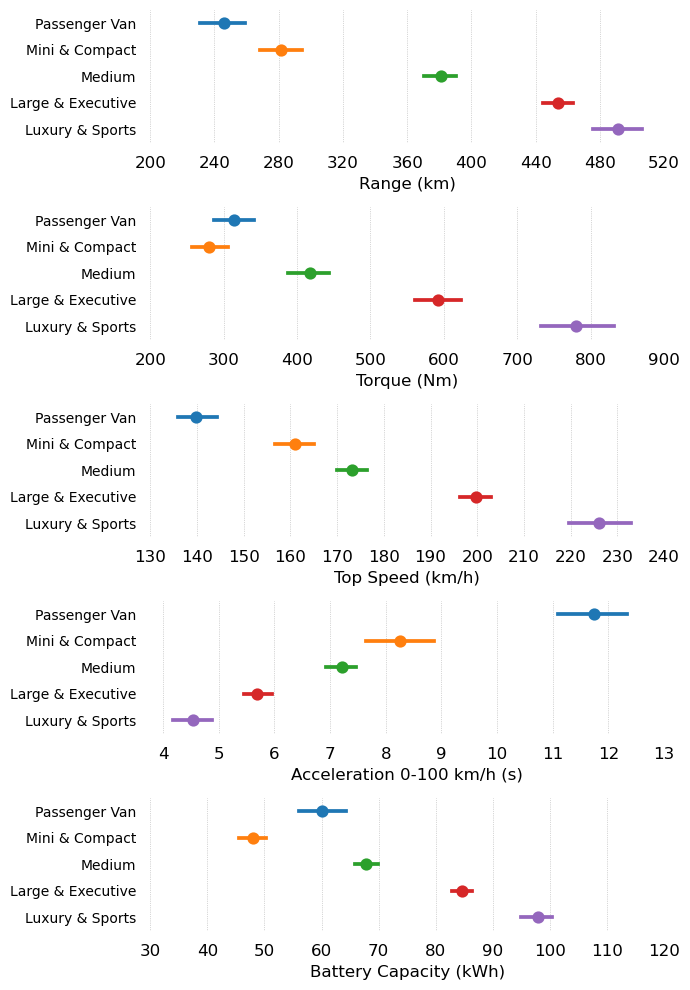

In [61]:
fig, axs = plt.subplots(figsize=(7,10), nrows=5, ncols=1, sharey=True)
for ax, feature in zip(axs.flatten(), features):
    sns.pointplot(df_torque,
                  x=feature,
                  y="new_segment",
                  order=segment_order,
                  linestyle="none",
                  hue="new_segment",
                  palette=segment_palette,
                  ax=ax)
    ax.set_xlabel(xlabel_map.get(feature), fontsize=12)
    ax.set_ylabel("")
    ax.grid(True, linewidth=0.5, linestyle=':', axis="x")
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
    ax.tick_params(axis="both", length=0, pad=10)

axs[0].set_xticks(np.arange(200,540,40), np.arange(200,540,40))
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=12)

# Torque
axs[1].set_xticks(np.arange(200,1000,100), np.arange(200,1000,100))
axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=12)

# Speed
axs[2].set_xticks(np.arange(130,250,10), np.arange(130,250,10))
axs[2].set_xticklabels(axs[2].get_xticklabels(), fontsize=12)

# Acceleration
axs[3].set_xticks(np.arange(4,14,1), np.arange(4,14,1))
axs[3].set_xticklabels(axs[3].get_xticklabels(), fontsize=12)

# Battery Capacity
axs[4].set_xticks(np.arange(30,130,10), np.arange(30,130,10))
axs[4].set_xticklabels(axs[4].get_xticklabels(), fontsize=12)
    
fig.tight_layout()

## 4.3 Torque, Acceleration and Top speed by vehicle segment

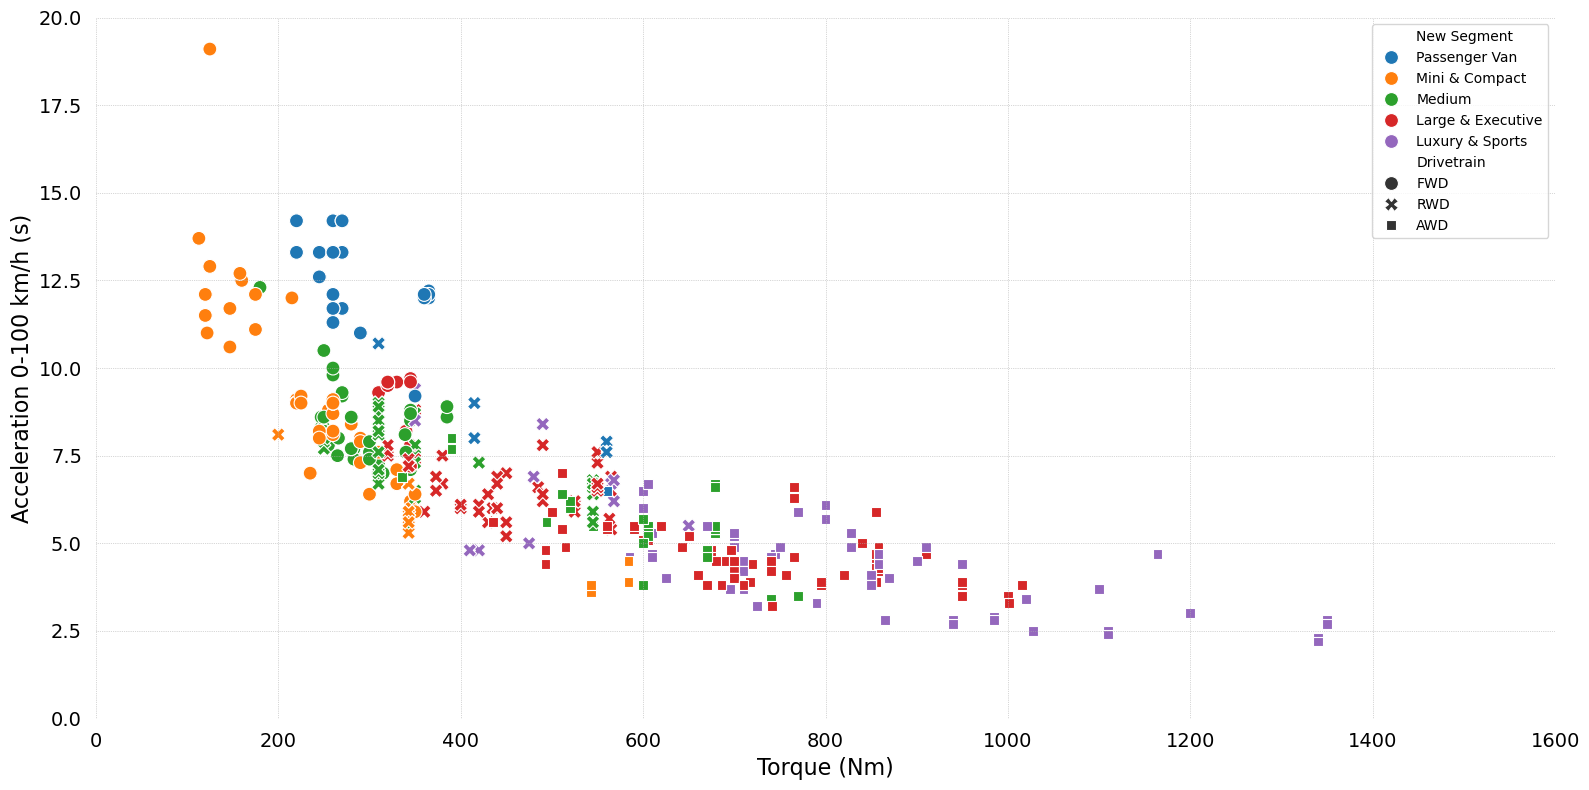

In [62]:
fig, ax = plt.subplots(figsize=(16,8))
# Torque vs acceleration
sns.scatterplot(df.rename(columns=xlabel_map),
                x="Torque (Nm)",
                y="Acceleration 0-100 km/h (s)",
                hue="New Segment",
                hue_order=segment_order,
                palette=segment_palette,
                style="Drivetrain",
                s=100,
                ax=ax)
# Edit the plot
ax.grid(True, linewidth=0.5, linestyle=":")
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis="both", length=0, pad=10)
fig.tight_layout()

In [63]:
mean_torque = df_torque.torque_nm.mean()
mean_torque

np.float64(498.0127388535032)

In [64]:
total_count_AWD = df_torque[(df_torque["drivetrain"] == "AWD")]["model"].count()
count_count_AWD_greater_than_m =df_torque[(df_torque["drivetrain"] == "AWD") & (df_torque["torque_nm"] > mean_torque)]["model"].count()

print(round((count_count_AWD_greater_than_m / total_count_AWD)*100, 1), "% of AWD vehicles with greater torque than the mean 498.01 Nm")

94.6 % of AWD vehicles with greater torque than the mean 498.01 Nm


In [65]:
luxury_AWD = df_torque[(df_torque["drivetrain"] == "AWD") &
    (df_torque["new_segment"] == "Luxury & Sports")][["model", "drivetrain", "torque_nm"]].shape[0]
luxury_total = df_torque[(df_torque["new_segment"] 
                          == "Luxury & Sports")][["model", "drivetrain", "torque_nm"]].shape[0]
print(round((luxury_AWD/luxury_total)*100, 1), "% of Luxury & Sports vehicles are AWD")

82.1 % of Luxury & Sports vehicles are AWD


In [66]:
luxury_RWD = df_torque[(df_torque["drivetrain"] == "RWD") &
    (df_torque["new_segment"] == "Luxury & Sports")][["model", "drivetrain", "torque_nm"]].shape[0]
print(round((luxury_RWD/luxury_total)*100, 1), "% of Luxury & Sports vehicles are RWD")

17.9 % of Luxury & Sports vehicles are RWD


The seven missing vehicles with no torque data are not included in this part of the analysis.

94.6% of AWD vehicles have a higher values of torque than the mean of all vehicles (498.01 Nm), many of the RWD vehicles revolve around the mean value of the torque and all the FWD vehicles in the dataset have lower torque values than the mean of all vehicles.

The vehicles belonging to the _Mini & compact_ segment present low values of torque and long acceleration times, with very few exceptions such as the Smart Brabus, which is an AWD vehicle and has a torque value (584 Nm) greater than the mean.

Vehicles of the _Passenger Vans_ and _Medium_ segments can also be found on the lower end of the torque values which also translates in low acceleration times.

_Large & Executive_ vehicles are spread over a wide range of torque and acceleration values. The way they are distributed follows the trend  previously mentioned regrading the drivetrain, FWD vehicles are on the lower end of the torque and acceleration values, it then progresses to RWD vehicles with many vehicles revolving around the mean values of torque (498.01 Nm) and acceleration (6.88 s), and finally the AWD vehicles that overlap with those of the _Luxury & Sports_ segement.

_Luxury & Sports_ contains the vehicles with the highest torque and acceleration values, with 17.9% being RWD and 82.1% being AWD.

Text(0, 0.5, 'Top Speed (km/h)')

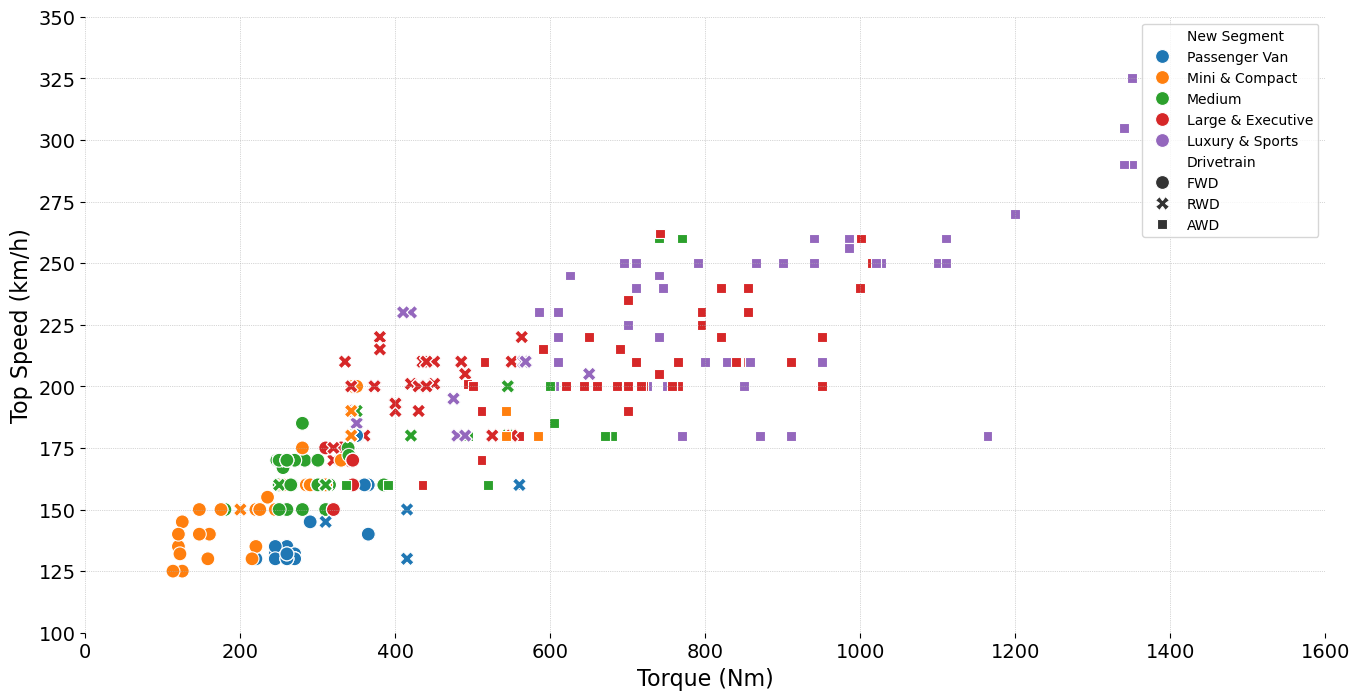

In [67]:
fig, ax = plt.subplots(figsize=(16,8))
# Torque vs acceleration
sns.scatterplot(df.rename(columns=xlabel_map),
                x="Torque (Nm)",
                y="Top Speed (km/h)",
                hue="New Segment",
                hue_order=segment_order,
                palette=segment_palette,
                style="Drivetrain",
                s=100,
                ax=ax)
# Edit the plot
ax.grid(True, linewidth=0.5, linestyle=":")
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)

In [68]:
df_torque[(df_torque["torque_nm"].between(700,800)) & (df_torque["new_segment"] == "Medium")]

,brand,model,top_speed_kmh,battery_capacity_kWh,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,fast_charging_power_kw_dc,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,efficiency_km_kWh,new_segment
142,Genesis,GV60 Sport Plus,235,74.0,700.0,159,360,4.0,200.0,1600.0,432,5,AWD,JC - Medium,4515,1890,1580,SUV,4.864865,Medium
153,Hyundai,IONIQ 5 N (MY24),260,80.0,740.0,179,390,3.4,205.0,0.0,480,5,AWD,JC - Medium,4715,1940,1585,SUV,4.875000,Medium
172,Kia,EV6 GT,260,80.0,770.0,178,385,3.5,205.0,1800.0,480,5,AWD,JC - Medium,4695,1890,1545,SUV,4.812500,Medium


The torque and top speed scatter plot shows similar trends to those of the previous scatter plot, which aligns with the expectation that the vehicles that have high acceleration values will also have high top speeds.

_Mini & Compact_ vehicles together with the _Passenger Vans_ show the lowest top speeds. Vehicles beloging to the _Medium segment_ have overall somwhat better top speed than the previous segments but there are some vehicles of this segment that show top speeds comparable to those of the _Large & Executive_ and _Luxury & Sports_ segments, such as the KIA EV6 and the Hyundai IONIQ 5 N, both reaching top speeds of 260 km/h with AWD drivetrains. The biggest overlap is still observed between the _Large & Executive_ and _Luxury & Sports_ segments

End of the note book